## Step 0. Install all the necessary modules and import them

`pip install scikit-learn pandas plotly seaborn opencv-python librosa tqdm`

In [16]:
# Data manipulation and analysis
import pandas as pd               # Data manipulation and analysis
import numpy as np               # Numerical computing

# Audio processing
import librosa                   # Audio feature extraction and analysis

# Image processing
import cv2                       # Computer vision operations

# Visualization
import matplotlib.pyplot as plt   # Basic plotting library
import seaborn as sns            # Statistical data visualization
import plotly.graph_objects as go # Interactive visualizations

# File handling and utilities
from pathlib import Path         # File path operations
from tqdm import tqdm           # Progress bar visualization
from sklearn.cluster import KMeans # Clustering algorithm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime    # Date and time operations

# # This block of code is only needed when running on the google drive else we can remove this
# from google.colab import drive
# drive.mount('/content/drive')

## Step 1. Read Main Source Data
This data is already available to us on Studon. Please download it from session named as: `28. Nov 2024, 14:00 - 16:00: Session 7: Intro multi-modal data sample`

We read the data from the CSV file containing environmental measurements and sentiment tags.
> **Ensure the CSV file exists in the specified path before running this code block.**



### TODO: Pass Correct Path to Data Directory

In [17]:
# please change this code as per need
data_path=Path(r'D:\AllProjects\multi-modller\team1\Session_28_11_24')

In [18]:
### Read and Load Data
# Read CSV file into pandas DataFrame


# Display first few rows of the DataFrame
# This helps verify data loading and examine structure
df.head()

,id,observationID,personID,lat,lon,media,Eventful_Uneventful,Exciting_Monotonous,Pleasant_Unpleasant,Calm_Chaotic,...,accessible_unaccessible,central_remote,green _built-up,clean_polluted,quiet_busy,relaxing_disturbing,mediaType,timestamp,transcription,filename
0,0,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266733009.aac,1,5,5,5,...,5,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266733009.aac
1,1,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266776456.aac,1,5,5,5,...,5,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266776456.aac
2,2,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266884668.aac,1,5,5,5,...,5,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266884668.aac
3,3,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266905336.jpg,1,5,5,5,...,5,3,2,5,4,5,Image,2024-06-13 10:18:53.014,NaN,1718266905336.jpg
4,4,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266913377.jpg,1,5,5,5,...,5,3,2,5,4,5,Image,2024-06-13 10:18:53.014,NaN,1718266913377.jpg


## Step 2. Read People and Vehicle Counts
This section processes vehicle and pedestrian detection data previously generated using the Ultralytics YOLO model.

*Technical Implementation:*
* Original detection performed using [Ultralytics YOLOv8](https://github.com/ultralytics/ultralytics) model.
* Due to computational constraints, we use pre-computed results stored in `persons_vehicles.csv`. This result was generated using the script below.

> Note: **Only following line of code is needed to be added below cell and run. Section ` Object Detection Implementation` is only to get ideas about how the data was prepared.**

```python
# Load pre-processed detection data
df_person_vehicle = pd.read_csv(data_path/'persons_vehicles.csv')
```

#### Object Detection Implementation
This code performs object detection on images using YOLO to count people and vehicles:
Key Components:
**Class Mapping**
*  Maps YOLO class IDs to simplified categories ('person' and 'vehicle')
*   Consolidates different vehicle types (car, bus, truck, etc.) into single 'vehicle' category


**Main Function:** count_objects_yolo()

*   Input: Image path and YOLO model version
*   Process:


    Loads and initializes YOLO model
    Converts image to RGB format
    Performs object detection
    Counts detected objects by category


*   Output: Returns detection results and object counts

*Implementation Note: Uses YOLOv8n model for efficient real-time object detection*

```python
from ultralytics import YOLO

# Dictionary mapping class IDs to class names
class_mapping = {
    0: 'person',        # person
    1: 'vehicle',       # bicycle
    2: 'vehicle',       # car
    3: 'vehicle',       # motorcycle
    5: 'vehicle',       # bus
    6: 'vehicle',       # train
    7: 'vehicle',       # truck
    8: 'vehicle',       # boat
}

def count_objects_yolo(image_path, model='yolov8n'):
    # Initialize YOLO model
    yolo = YOLO(model)

    # Load image using OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform prediction
    results = yolo.predict(img)

    # Initialize counts dictionary for 'person' and 'vehicle'
    counts = {
        'person': 0,
        'vehicle': 0
    }

    for result in results:
        summaries = result.summary()
        for summary in summaries:
          class_id = summary['class']
          if class_id in class_mapping:
              class_name = class_mapping[class_id]
              counts[class_name] += 1

    return result, counts

# Example usage:
result, count = count_objects_yolo(IMAGE_PATH)
```

Above function was run for each image files and the respective people count and vehicle count was stored.


### TODO: Read `persons_vehicles.csv` data
This file is expected to be present outside the folder `Session_28_11_24`

In [19]:
# please pass the file's name inside ''
## Person vehicle counts df
df_person_vehicle=pd.read_csv(data_path.parent/'persons_vehicles.csv')

In [20]:
# conversion of mediaID to integer
df_person_vehicle['mediaID']=df_person_vehicle['mediaID'].astype(int)
# conversion of observationID to integer
df_person_vehicle['observationID']=df_person_vehicle['observationID'].astype(int)

# checking first 5 rows of the data
df_person_vehicle.head()

,Unnamed: 0,observationID,mediaID,filename,person,vehicles
0,0,1718266733014,1718266905336,1718266905336.jpg,1.0,1.0
1,1,1718266733014,1718266913377,1718266913377.jpg,0.0,2.0
2,2,1718266733014,1718266921444,1718266921444.jpg,0.0,0.0
3,3,1718267618450,1718267828875,1718267828875.jpg,3.0,1.0
4,4,1718267618450,1718267836964,1718267836964.jpg,0.0,0.0


## Step 3. Merging Detection Data with Source Data

### 1. Prepare Data for Merging

First, let's examine the columns in both dataframes to identify joining keys:



In [21]:
# Display columns in both dataframes


#### Process File Names

The source data contains full file paths. We need to extract just the filename for merging:

In [22]:
# Extract filename from media path
df['filename'] = df['media'].str.split('/').str[-1]

# Display modified dataframe
df.head()


,id,observationID,personID,lat,lon,media,Eventful_Uneventful,Exciting_Monotonous,Pleasant_Unpleasant,Calm_Chaotic,...,accessible_unaccessible,central_remote,green _built-up,clean_polluted,quiet_busy,relaxing_disturbing,mediaType,timestamp,transcription,filename
0,0,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266733009.aac,1,5,5,5,...,5,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266733009.aac
1,1,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266776456.aac,1,5,5,5,...,5,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266776456.aac
2,2,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266884668.aac,1,5,5,5,...,5,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266884668.aac
3,3,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266905336.jpg,1,5,5,5,...,5,3,2,5,4,5,Image,2024-06-13 10:18:53.014,NaN,1718266905336.jpg
4,4,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266913377.jpg,1,5,5,5,...,5,3,2,5,4,5,Image,2024-06-13 10:18:53.014,NaN,1718266913377.jpg


#### 3. Filter and Merge Data

In [23]:
print(df1)

      id  observationID personID        lat       lon  \
3      3  1718266733014      P07  49.800366  9.932352   
4      4  1718266733014      P07  49.800366  9.932352   
5      5  1718266733014      P07  49.800366  9.932352   
9      9  1718267618450      P07  49.795487  9.929723   
10    10  1718267618450      P07  49.795487  9.929723   
..   ...            ...      ...        ...       ...   
453  453  1718277918503      p18  49.795410  9.933191   
454  454  1718277918503      p18  49.795410  9.933191   
458  458  1718278344068      p18  49.796784  9.935571   
459  459  1718278344068      p18  49.796784  9.935571   
460  460  1718278344068      p18  49.796784  9.935571   

                                         media  Eventful_Uneventful  \
3    P07/1718266733014/media/1718266905336.jpg                    1   
4    P07/1718266733014/media/1718266913377.jpg                    1   
5    P07/1718266733014/media/1718266921444.jpg                    1   
9    P07/1718267618450/media/17

In [24]:
# Filter for image entries only
df1 = df[df['mediaType']=='Image'].copy()

# Merge dataframes on filename
mdf = pd.merge(df1, df_person_vehicle, on='filename')

# Clean up duplicate columns
mdf.rename(columns={'observationID_x':'observationID'}, inplace=True)
del mdf['observationID_y']

#### Distribution of Person and Vehicle Counts

In [25]:
mdf.to_csv('processed_mdf.csv', index=False)

mdf.head()

,id,observationID,personID,lat,lon,media,Eventful_Uneventful,Exciting_Monotonous,Pleasant_Unpleasant,Calm_Chaotic,...,quiet_busy,relaxing_disturbing,mediaType,timestamp,transcription,filename,Unnamed: 0,mediaID,person,vehicles
0,3,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266905336.jpg,1,5,5,5,...,4,5,Image,2024-06-13 10:18:53.014,NaN,1718266905336.jpg,0,1718266905336,1.0,1.0
1,4,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266913377.jpg,1,5,5,5,...,4,5,Image,2024-06-13 10:18:53.014,NaN,1718266913377.jpg,1,1718266913377,0.0,2.0
2,5,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266921444.jpg,1,5,5,5,...,4,5,Image,2024-06-13 10:18:53.014,NaN,1718266921444.jpg,2,1718266921444,0.0,0.0
3,9,1718267618450,P07,49.795487,9.929723,P07/1718267618450/media/1718267828875.jpg,2,1,1,2,...,2,2,Image,2024-06-13 10:33:38.450,NaN,1718267828875.jpg,3,1718267828875,3.0,1.0
4,10,1718267618450,P07,49.795487,9.929723,P07/1718267618450/media/1718267836964.jpg,2,1,1,2,...,2,2,Image,2024-06-13 10:33:38.450,NaN,1718267836964.jpg,4,1718267836964,0.0,0.0


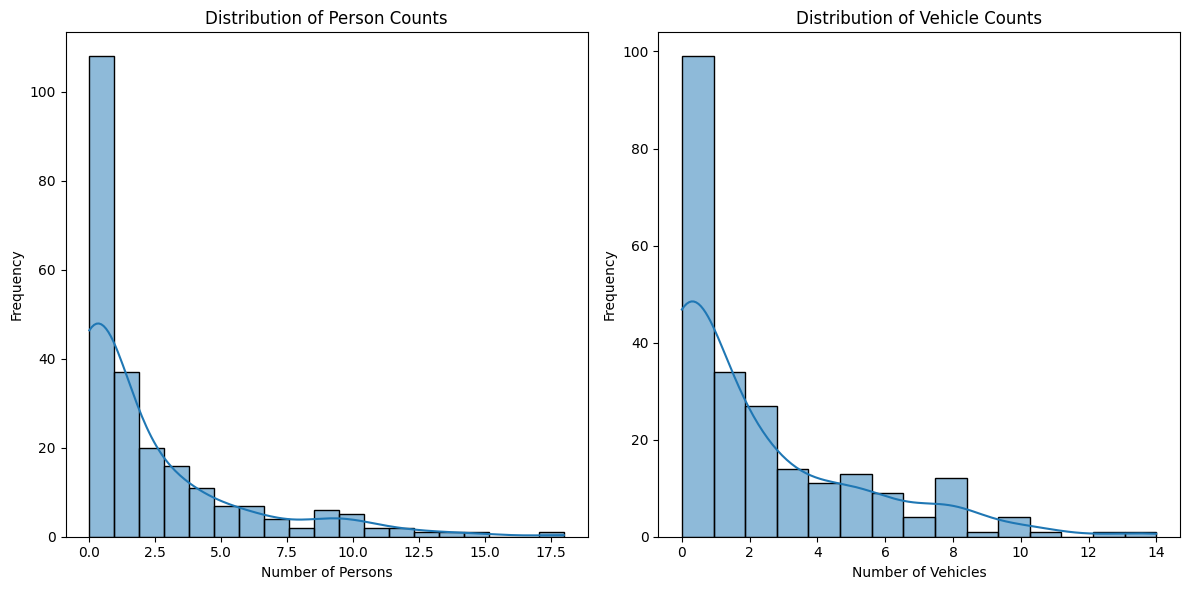

In [26]:
# Distribution of Person and Vehicle Counts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(mdf['person'], kde=True)
plt.title('Distribution of Person Counts')
plt.xlabel('Number of Persons')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(mdf['vehicles'], kde=True)
plt.title('Distribution of Vehicle Counts')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Step 4. Location Clustering

### Overview
Before analyzing relationships between environmental features and sentiment, we need to:

1. Extract features from images
2. Group observations by location
3. Assign meaningful names to location clusters

### Location Clustering with K-Means
We'll use K-Means clustering to group our data points into 5 major locations.

### K-Means Algorithm Explanation

```
K-Means Clustering Process:
1. Initialize: Select K random centroids
2. Assign: Group points to nearest centroid
3. Update: Recalculate centroids based on assignments
4. Repeat: Until convergence or max iterations reached
```

### Implementation

**1. Apply K-Means Clustering**



In [27]:
# Extract coordinates for clustering
coords = mdf[['lat','lon']].values

In [28]:
# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(coords)

# Add cluster labels to dataframe
mdf['place_cluster'] = kmeans.labels_

### Visualize Person Counts on Map

In [29]:
# Calculate scaling for visualization
max_value = mdf['person'].max()
scaling_factor = 1000 / max_value

# Create map visualization
traces = []
polygons = []
place_clusters = sorted(mdf.place_cluster.unique())

# Add data points for each cluster
for cluster in place_clusters:
    cluster_data = mdf[mdf['place_cluster'] == cluster]
    trace = go.Scattermapbox(
        lat=cluster_data['lat'],
        lon=cluster_data['lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=cluster_data['person'] * scaling_factor,
            sizemode='area',
            sizeref=2.*max(cluster_data['person'] * scaling_factor)/(40.**2),
        ),
        name=f"Place {cluster}"
    )
    traces.append(trace)

# Create and configure map
fig = go.Figure(traces + polygons)
fig.update_layout(
    width=500,
    height=500,
    mapbox=dict(
        style="open-street-map",
        zoom=12,
        center=dict(lat=mdf['lat'].mean(), lon=mdf['lon'].mean())
    ),
    margin={"r":0,"t":0,"l":0,"b":0}
)
fig.show()

### Exploration: Visualize Vehicle Counts on Map

### 3. Assign Location Names
Based on the visualization, we can map cluster IDs to actual locations:

### TODO: Assign Place name to Cluster Ids

> Cluster ID vary based on the random initialization but to make sure all of us have the same place name, we should assign place name manually.

It is important for correct analysis in further steps. **Please zoom into the above plot by clicking on the + symbol on top right panel of the plot.** Then fill the dictionary below. In our case, it was:

```python
mapping = {
    0: "Semmelstr",
    1: "Dommerschulstr",
    2: "Katharinengasse/Marienplatz",
    3: "Klinikstr",
    4: "Eichhornstr"
}
```

In [30]:
# Define location mapping
mapping = {
    0: "Semmelstr",
    1: "Dommerschulstr",
    2: "Katharinengasse/Marienplatz",
    3: "Klinikstr",
    4: "Eichhornstr"
}

In [31]:
# Add location names to dataframe
mdf['place_name'] = mdf['place_cluster'].map(mapping)

## Step 5. Image Feature Extration: Greenness and Brightness Extraction

### Overview
This section covers a Python implementation for analyzing images to extract:
*   Greenness - A measure of vegetation presence based on RGB channel differences
*   Brightness - Average intensity across color channels


### Greenness Calculation

In [32]:
import numpy as np

def calculate_greeness(data: np.ndarray) -> float:
    """
    Calculate the greenness of an image using RGB channel differences.

    The formula identifies vegetation presence through two conditions:
    1. G-R > 0 (Diff_1)
    2. G-B > 0 (Diff_2)
    Vegetation is present when both conditions are true and their product is positive.

    Args:
        data (np.ndarray): Input image array in RGB format with shape (H, W, 3)

    Returns:
        float: Proportion of pixels identified as green vegetation (0 to 1)
    """
    data = data.astype(np.float64)

    # Extract RGB channels
    blue_channel, green_channel, red_channel = data[:, :, 0], data[:, :, 1], data[:, :, 2]

    # Calculate differences
    Diff_1 = green_channel - red_channel
    Diff_2 = green_channel - blue_channel
    Diff = Diff_1 * Diff_2

    # Identify green vegetation pixels
    greens = np.logical_and(Diff > 0, Diff_1 > 0)

    # Calculate proportion of green pixels
    portion_green = np.sum(greens) / (data.shape[0] * data.shape[1])

    return portion_green

###Function to calculate Average Red, Blue, Green and Brightness Value

Hint: `np.mean(array)` gives the average value.

In [33]:
def calculate_brightness(image: np.ndarray) -> dict:
    """
    Calculate average brightness metrics for an image.

    Args:
        image (np.ndarray): Input image array in BGR format

    Returns:
        dict: Dictionary containing:
            - 'brightness': Overall average brightness (0-255)
            - 'b': Average blue channel intensity
            - 'g': Average green channel intensity
            - 'r': Average red channel intensity
    """
    # Split channels
    b, g, r = cv2.split(image)

    # Calculate channel averages
    avg_b = np.mean(b)
    avg_g = np.mean(g)
    avg_r = np.mean(r)

    # Calculate overall brightness

    # Calculate overall brightness
    avg_int = (avg_b + avg_g + avg_r) / 3

    return {
        'brightness': int(avg_int),
        'b': avg_b,
        'g': avg_g,
        'r': avg_r
    }

### Populating Dataframe with Values

### Utilizing Methods

In [34]:
# to visualize the progress bar
pbar = tqdm(total=len(mdf))

# start a loop with length of our data
for i in range(len(mdf)):
    # prepare the correct file path of an image
    img_path = data_path / mdf.loc[i, 'media']

    # update the progress bar by 1
    pbar.update(1)

    # set description on progress bar
    pbar.set_description(f"Processing {img_path.name}")

    # to handle missing images
    if not img_path.exists():
        print(f"File not found: {img_path} \n")
        continue

    # Load and process image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Calculate metrics
    # TODO: Please call the correct function
    brightness = calculate_brightness(img)

    # Update DataFrame
    mdf.loc[i, 'avg_r'] = brightness['r']
    mdf.loc[i, 'avg_g'] = brightness['g']
    mdf.loc[i, 'avg_b'] = brightness['b']
    mdf.loc[i, 'brightness'] = brightness['brightness']

    # TODO: Please call the correct function
    mdf.loc[i, 'greeness'] = calculate_greeness(img)

pbar.close()

Processing 1718266905336.jpg:   0%|          | 1/231 [00:00<00:00, 1002.70it/s]

Processing 1718278643246.jpg: 100%|██████████| 231/231 [03:31<00:00,  1.09it/s]


### Distribution of Brightness Values amd Greeness Values
Now we try to view the distribution of it.

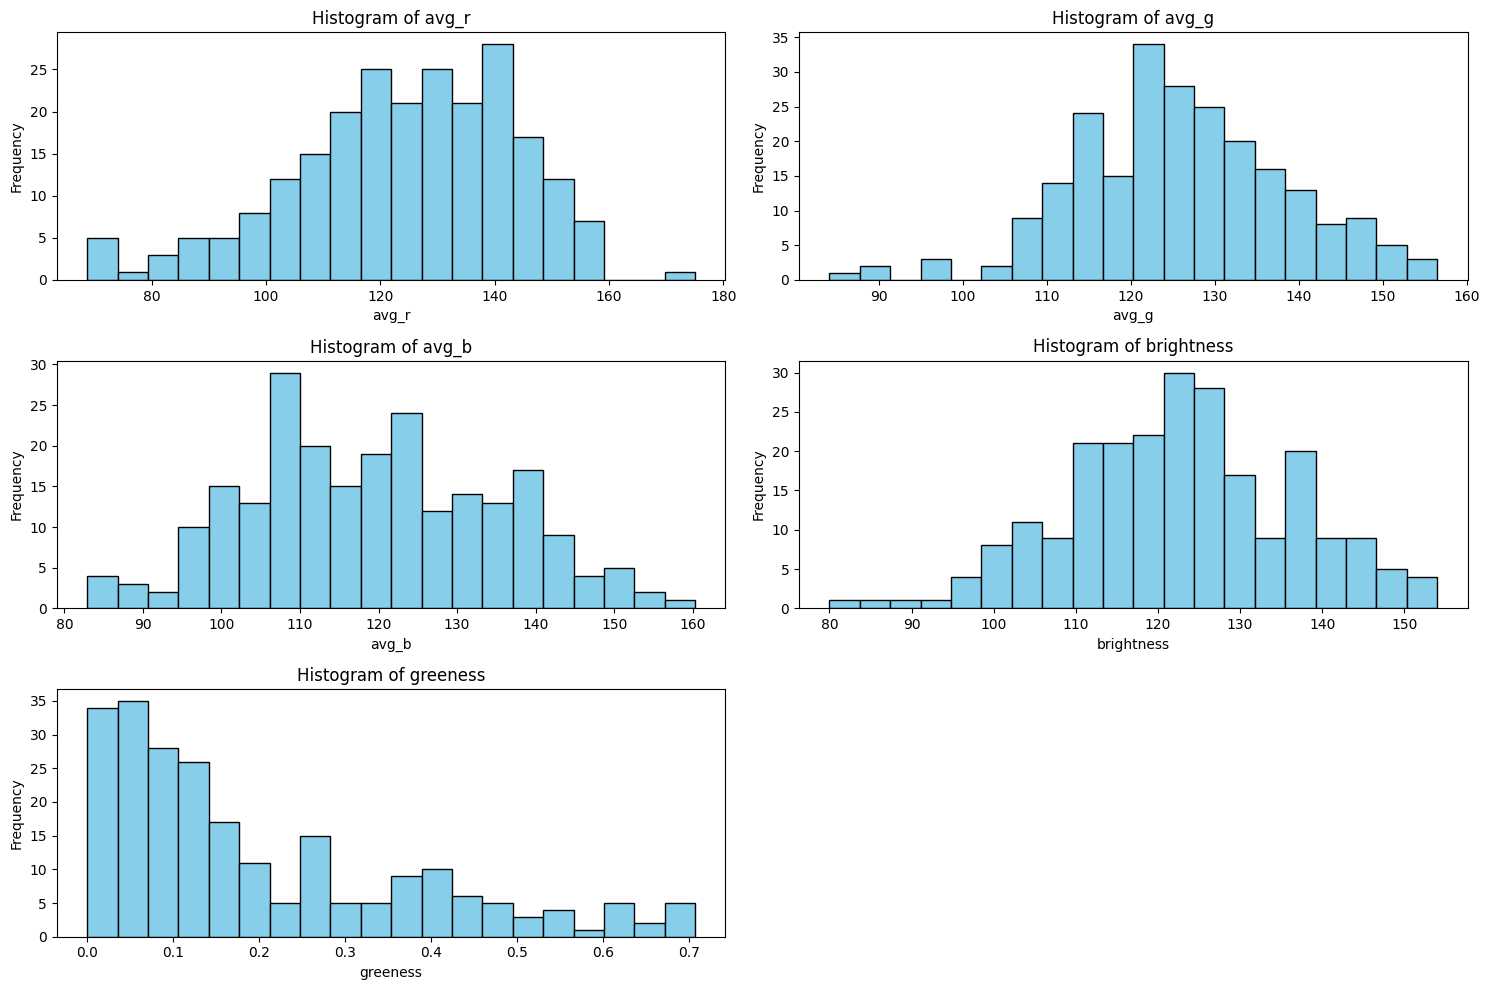

In [35]:
# Create a list of columns to plot
columns_to_plot = ['avg_r', 'avg_g', 'avg_b', 'brightness', 'greeness']

# Calculate the number of rows and columns for the subplots
num_plots = len(columns_to_plot)
num_cols = 2  # Adjust number of columns as desired
num_rows = (num_plots + num_cols - 1) // num_cols

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))  # Adjust figure size as needed
axes = axes.flatten()

# Iterate over the columns and plot histograms
for i, column in enumerate(columns_to_plot):
    axes[i].hist(mdf[column], bins=20, color='skyblue', edgecolor='black')  # Adjust bins as needed
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Map Density Plot for Greeness
And visualizing the greeness value on map.

In [36]:
import plotly.graph_objects as go

# Normalize greeness for visualization
mdf['normalized_greeness'] = mdf['greeness'] / mdf['greeness'].max()

# Create a heatmap using Densitymapbox
heatmap = go.Densitymapbox(
    lat=mdf['lat'],
    lon=mdf['lon'],
    z=mdf['normalized_greeness'],  # Use normalized greeness values for intensity
    radius=20,                     # Adjust the radius for smoothness
    colorscale="Viridis",          # Color scheme for heatmap
    showscale=True,                # Display color scale
    colorbar=dict(
        title="Greeness",          # Title for the color bar
        titleside="right",
        ticks="outside"
    ),
    hoverinfo="skip",              # Skip default hover info
    hovertemplate=(
        "<b>Place:</b> %{lat}, %{lon}<br>" +
        "<b>Greeness:</b> %{z:.2f}<br>" +
        "<extra></extra>"
    ),
)

# Configure the map layout
fig = go.Figure(heatmap)
fig.update_layout(
    mapbox=dict(
        style="open-street-map",   # Background map style
        center=dict(lat=mdf['lat'].mean(), lon=mdf['lon'].mean()),
        zoom=12                   # Adjust zoom level
    ),
    width=800,                     # Set width of the figure
    height=600,                    # Set height of the figure
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

# Display the map
fig.show()


### Exploration: Density Map Plot for Brightness Level

## Step 6. Audio Feature Extraction: Environmental Noise Analysis

### Overview
This code analyzes audio files to extract noise levels using the decibel (dB) scale. It processes a dataset containing audio recordings and calculates their respective noise levels using the RMS (Root Mean Square) method.


### Data Preparation:

In [37]:
# Check available audio files
df.mediaType.value_counts()


mediaType
Image    231
Audio    230
Name: count, dtype: int64

#### Select data with only `Audio` data type

Hint: `adf = df[df.media_column == Media_Value].copy()`

> We need to make the copy of the original dataframe to avoid warnings from pandas.

In [38]:
# Create audio-only DataFrame
adf = df[df.mediaType=='Audio'].copy()

### Noise Level Calculation:
This method will use `librosa` a package to handle audio files. The formula to calculate db from:

$L_{\text{dB}} = 10 \cdot \log_{10} \left( \frac{1}{N} \sum_{n=1}^{N} x[n]^2 \right)$

Where,
* $x[n]$ is the aplitude at time step n
* N is total number of samples in a signal and is formulated as: total length of a signal multiplied by samples per second

#### Noise Level Calculation
Based on the formula above, we try to extract the dB value.

In [39]:
def calculate_noise_level(audio_file: Path) -> float:
    """
    Calculate the noise level of an audio file in decibels (dB).

    Uses the formula: LdB = 10 * log10(1/N * Σ(x[n]²))
    where:
    - x[n] is the amplitude at time step n
    - N is total number of samples (duration * sample_rate)

    Args:
        audio_file (Path): Path to the audio file

    Returns:
        float: Noise level in decibels (dB)
    """
    # Load audio file with original sampling rate
    signal, sr = librosa.load(audio_file, sr=None)

    signal_square = np.square(signal)
    signal_square_mean = np.mean(signal_square)
    rms = np.sqrt(signal_square_mean)

    # Convert RMS to dB
    # 20 is here just as a scaling factor
    noise_level_db = 20 * np.log10(rms)

    return noise_level_db

### Populating noise value in Dataframe

In [40]:

pbar = tqdm(total=len(adf))

for i, row in adf.iterrows():
    aud_path = data_path / adf.loc[i, 'media']
    pbar.update(1)
    pbar.set_description(f"Processing {aud_path.name}")

    if not aud_path.exists():
        print(f"File not found: {aud_path} \n")
        continue

    adf.loc[i, 'noise'] = calculate_noise_level(aud_path)

pbar.close()

Processing 1718278551889.aac: 100%|██████████| 230/230 [00:43<00:00,  5.28it/s]


### Distribution of Noise Level

Distribution plot.

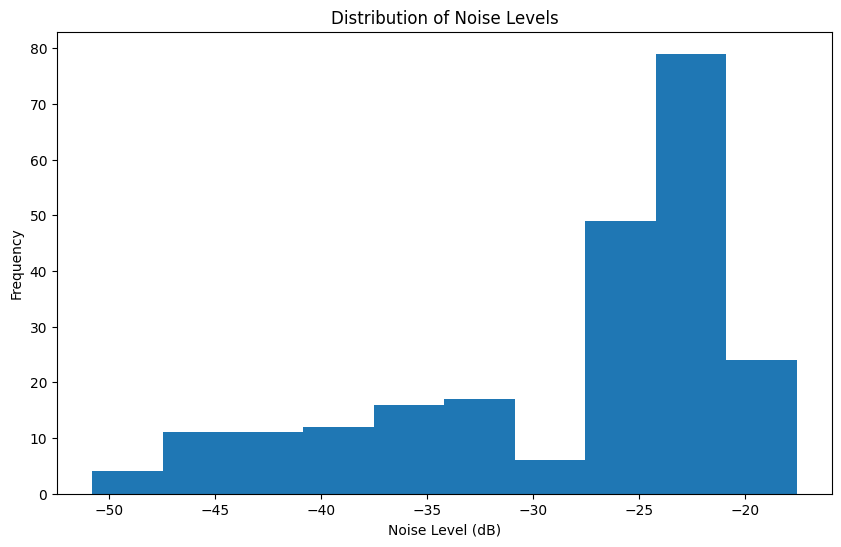

In [41]:
# Replace infinite values with NaN
adf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create histogram
plt.figure(figsize=(10, 6))
adf.noise.plot(kind='hist')
plt.title('Distribution of Noise Levels')
plt.xlabel('Noise Level (dB)')
plt.ylabel('Frequency')
plt.show()


## Step 7. Data Integration: Merging Noise and Image Features

### Overview
Here we merge the audio noise level data with our existing image features DataFrame. Since each observation can have multiple audio recordings, we aggregate the noise levels by taking their mean before merging.

#### Data Statistics



*  Checking audio DataFrame dimensions



In [42]:
adf.shape  # Shows dimensions of audio feature DataFrame
adf.head() # Preview audio feature DataFrame

,id,observationID,personID,lat,lon,media,Eventful_Uneventful,Exciting_Monotonous,Pleasant_Unpleasant,Calm_Chaotic,...,central_remote,green _built-up,clean_polluted,quiet_busy,relaxing_disturbing,mediaType,timestamp,transcription,filename,noise
0,0,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266733009.aac,1,5,5,5,...,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266733009.aac,-21.575068
1,1,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266776456.aac,1,5,5,5,...,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266776456.aac,-21.575068
2,2,1718266733014,P07,49.800366,9.932352,P07/1718266733014/media/1718266884668.aac,1,5,5,5,...,3,2,5,4,5,Audio,2024-06-13 10:18:53.014,"Ja gut, okay, nochmal neu. Also ich fühle mic...",1718266884668.aac,-21.575068
6,6,1718267618450,P07,49.795487,9.929723,P07/1718267618450/media/1718267618446.aac,2,1,1,2,...,1,5,2,2,2,Audio,2024-06-13 10:33:38.450,"Okay, ich fühle mich hier nicht wohl, aber wo...",1718267618446.aac,-31.789654
7,7,1718267618450,P07,49.795487,9.929723,P07/1718267618450/media/1718267698930.aac,2,1,1,2,...,1,5,2,2,2,Audio,2024-06-13 10:33:38.450,"Okay, ich fühle mich hier nicht wohl, aber wo...",1718267698930.aac,-31.789654


### Data Aggregation Process
#### Challenge

***Issue: Direct merging is problematic due to:***


*   Duplicate values in observationID
*   Repeated latitude/longitude coordinates


*  Multiple audio recordings per observation

***Solution:***

1. Calculate Mean Noise Levels

In [43]:
# Create dictionary of mean noise levels per observation
obs_noise_lvl = adf.groupby('observationID').noise.mean().to_dict()



*   *Groups data by unique observationID*
*  *Calculates mean noise level for each group*
*   *Converts result to dictionary format*

2. Merge with Image Features







In [44]:
# Add noise levels to main DataFrame using observation IDs
# here, the `obs_noise_lvl.get` will get the value of each observationID
mdf['noise'] = mdf.observationID.apply(obs_noise_lvl.get)

*  *Uses dictionary lookup to add noise values*
*   *Matches based on observationID*
*   *Maintains DataFrame structure*

Now we can plot noise level value on map too.

In [45]:
# Normalize noise for visualization
mdf['normalized_noise'] = mdf['noise'] / mdf['noise'].max()

# Create a heatmap using Densitymapbox
heatmap = go.Densitymapbox(
    lat=mdf['lat'],
    lon=mdf['lon'],
    z=mdf['normalized_noise'],  # Use normalized noise values for intensity
    radius=20,                     # Adjust the radius for smoothness
    colorscale="Viridis",          # Color scheme for heatmap
    showscale=True,                # Display color scale
    colorbar=dict(
        title="Noise Level",          # Title for the color bar
        titleside="right",
        ticks="outside"
    ),
    hoverinfo="skip",              # Skip default hover info
    hovertemplate=(
        "<b>Place:</b> %{lat}, %{lon}<br>" +
        "<b>Noise:</b> %{z:.2f}<br>" +
        "<extra></extra>"
    ),
)

# Configure the map layout
fig = go.Figure(heatmap)
fig.update_layout(
    mapbox=dict(
        style="open-street-map",   # Background map style
        center=dict(lat=mdf['lat'].mean(), lon=mdf['lon'].mean()),
        zoom=12                   # Adjust zoom level
    ),
    width=800,                     # Set width of the figure
    height=600,                    # Set height of the figure
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

# Display the map
fig.show()


## Step 8. Analysis

Now that we have extracted features from image and audio file, we can start the analysis process.

### Correlation Plots

To find the correlations, we need to first prepare the numerical columns.

In [46]:
mdf.columns

Index(['id', 'observationID', 'personID', 'lat', 'lon', 'media',
       'Eventful_Uneventful', 'Exciting_Monotonous', 'Pleasant_Unpleasant',
       'Calm_Chaotic', 'Anxious_Safe', 'Stressed_Relaxed',
       'Depressed_Cheerful', 'Detached_Attached', 'Exhausted_Excited',
       'uncrowded _crowded', 'accessible_unaccessible', 'central_remote',
       'green _built-up', 'clean_polluted', 'quiet_busy',
       'relaxing_disturbing', 'mediaType', 'timestamp', 'transcription',
       'filename', 'Unnamed: 0', 'mediaID', 'person', 'vehicles',
       'place_cluster', 'place_name', 'avg_r', 'avg_g', 'avg_b', 'brightness',
       'greeness', 'normalized_greeness', 'noise', 'normalized_noise'],
      dtype='object')

#### Exploration: Preparing Numerical Columns

Hint: Please make sure to select all calculated features: `'person', 'vehicles', 'avg_r', 'avg_g', 'avg_b', 'brightness', 'greeness', 'noise'`. And some sentiment tags too.

All numerical columns are below but the plot will be too big and gets hard to look into.

```python
  ['Eventful_Uneventful', 'Exciting_Monotonous', 'Pleasant_Unpleasant',
       'Calm_Chaotic', 'Anxious_Safe', 'Stressed_Relaxed',
       'Depressed_Cheerful', 'Detached_Attached', 'Exhausted_Excited',
       'uncrowded _crowded', 'accessible_unaccessible', 'central_remote',
       'green _built-up', 'clean_polluted', 'quiet_busy',
       'relaxing_disturbing','person', 'vehicles',
       'avg_r', 'avg_g', 'avg_b', 'brightness',
       'greeness', 'noise']
```


In [47]:
numerical_cols =  ['Eventful_Uneventful', 'Exciting_Monotonous', 'Pleasant_Unpleasant',
       'Calm_Chaotic', 'Anxious_Safe', 'Stressed_Relaxed',
       'Depressed_Cheerful', 'relaxing_disturbing','person', 'vehicles','brightness',
       'greeness', 'noise']
       

#### A method to plot correlation

In [48]:
def plot_corr(corr_data:pd.DataFrame, title:str, fig_name:str):
  correlation_matrix = corr_data.corr().round(3)

  # Create a mask to hide the upper triangle (including the diagonal)
  mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

  # Create a heatmap with the mask and adjust figsize
  plt.figure(figsize=(20, 10))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
  plt.title(title)
  plt.savefig(fig_name.replace('/','_'))
  plt.ylabel('Features')
  plt.xlabel('Features')
  plt.show()


#### Based on Places


##### Loop through unique place names and plot correlation

Hint: `df.[column_name].unique()`, `df[df.column_name==column_value][interesting_columns]`

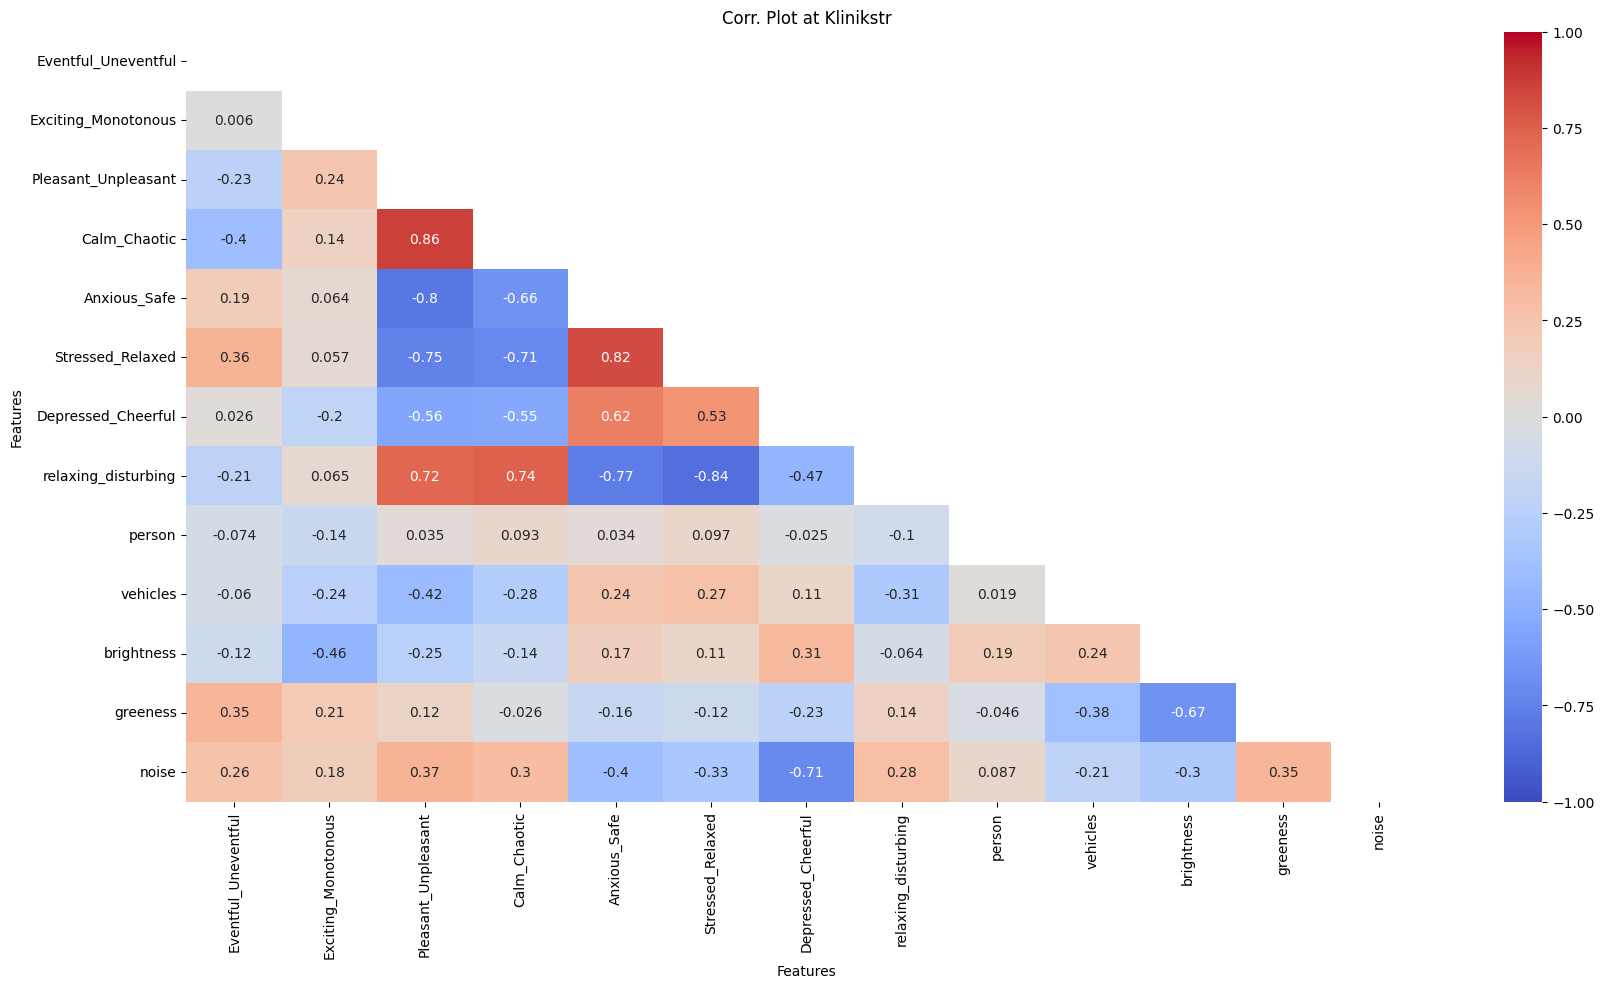

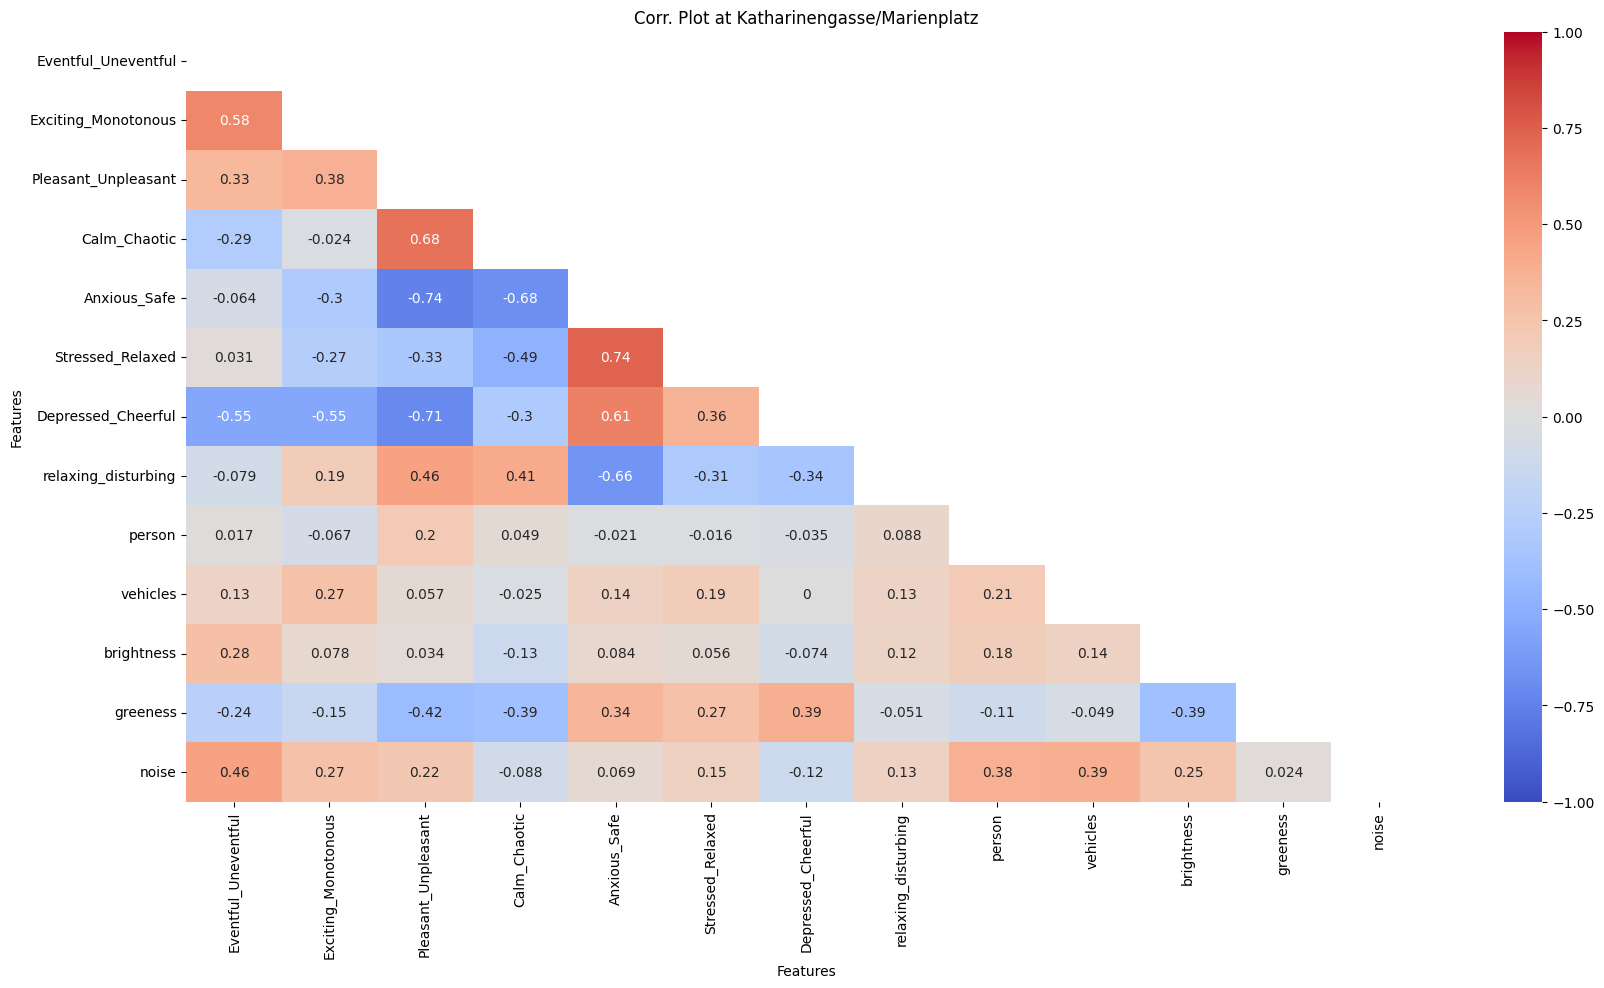

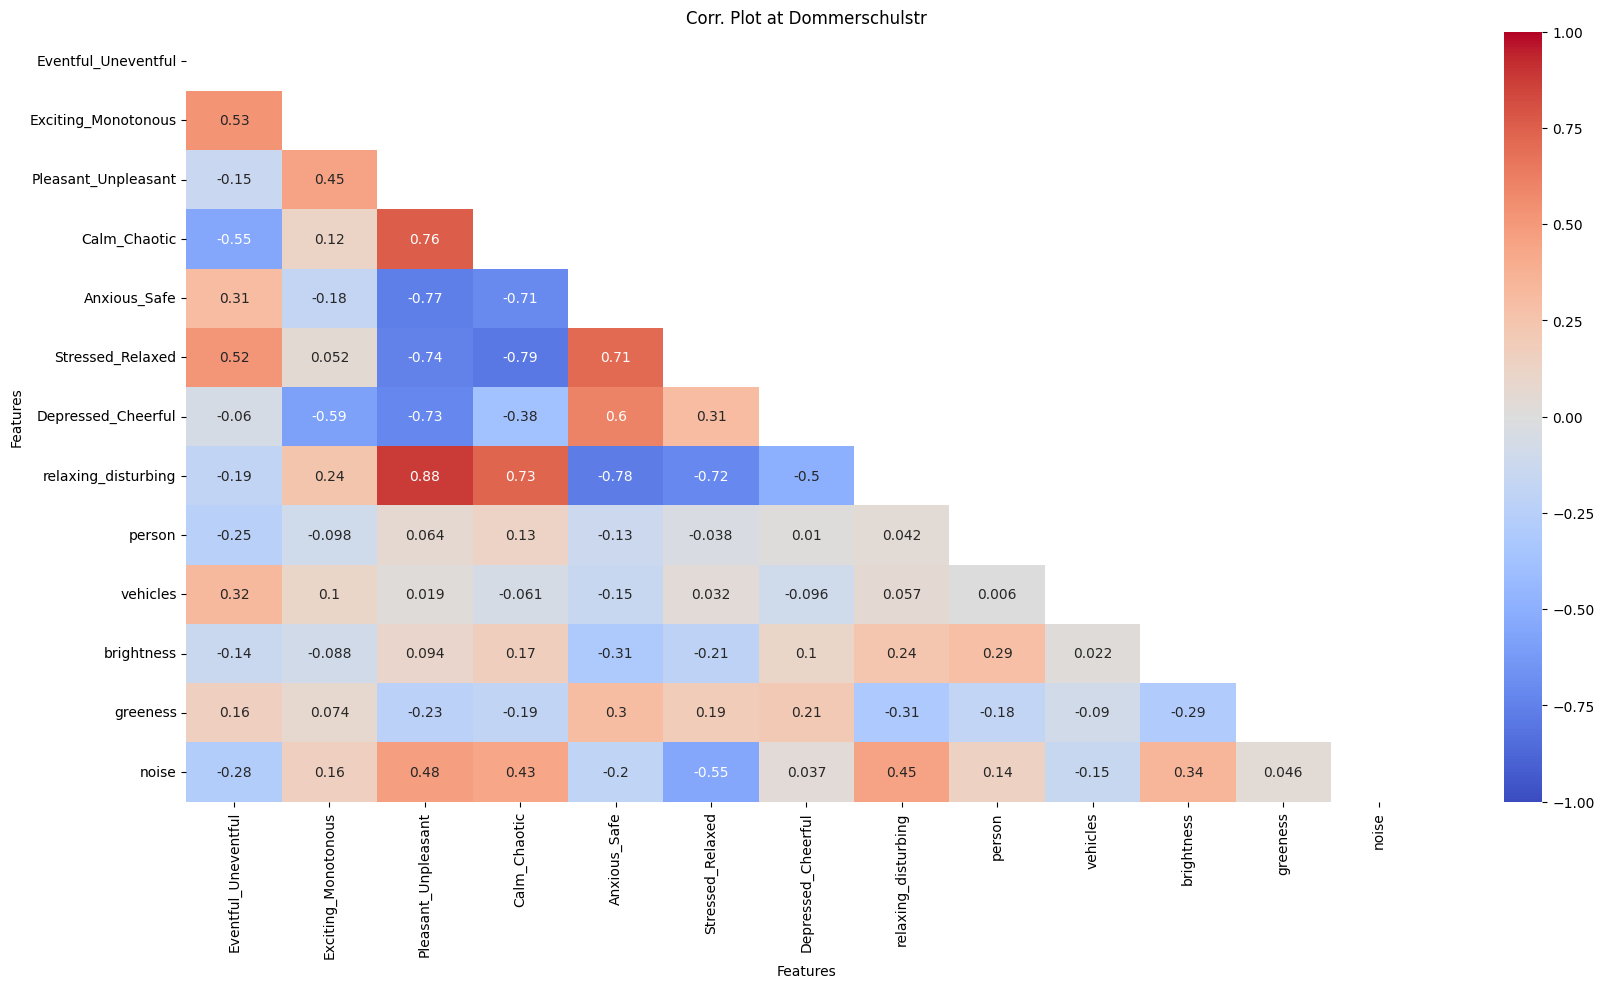

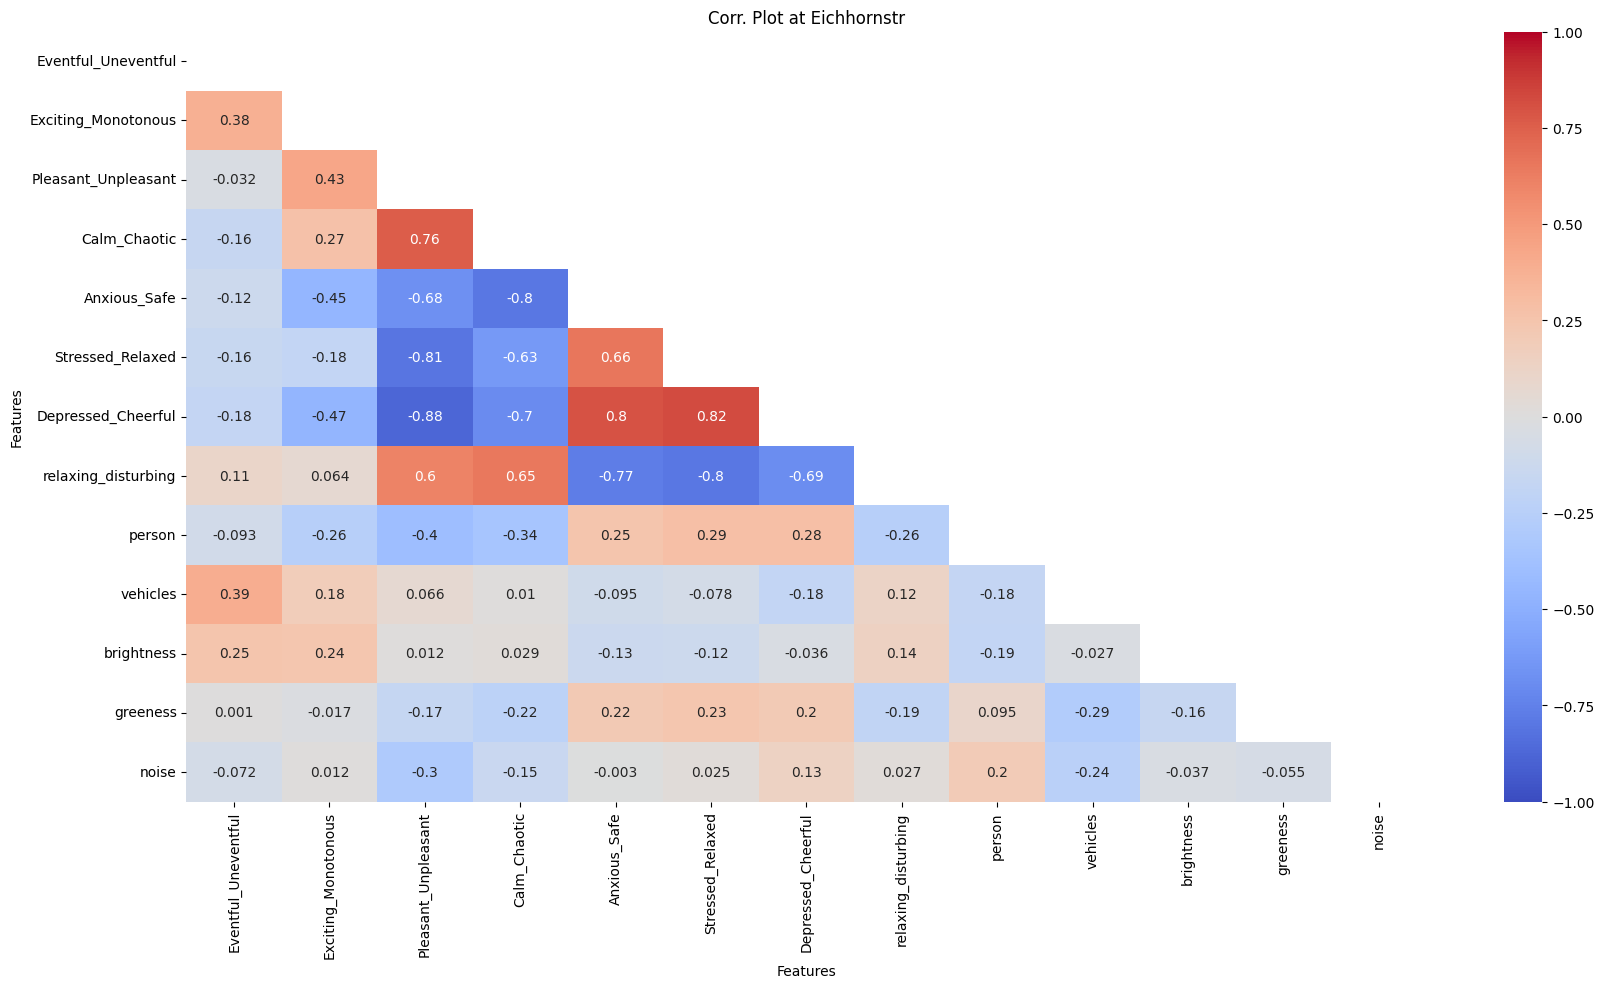

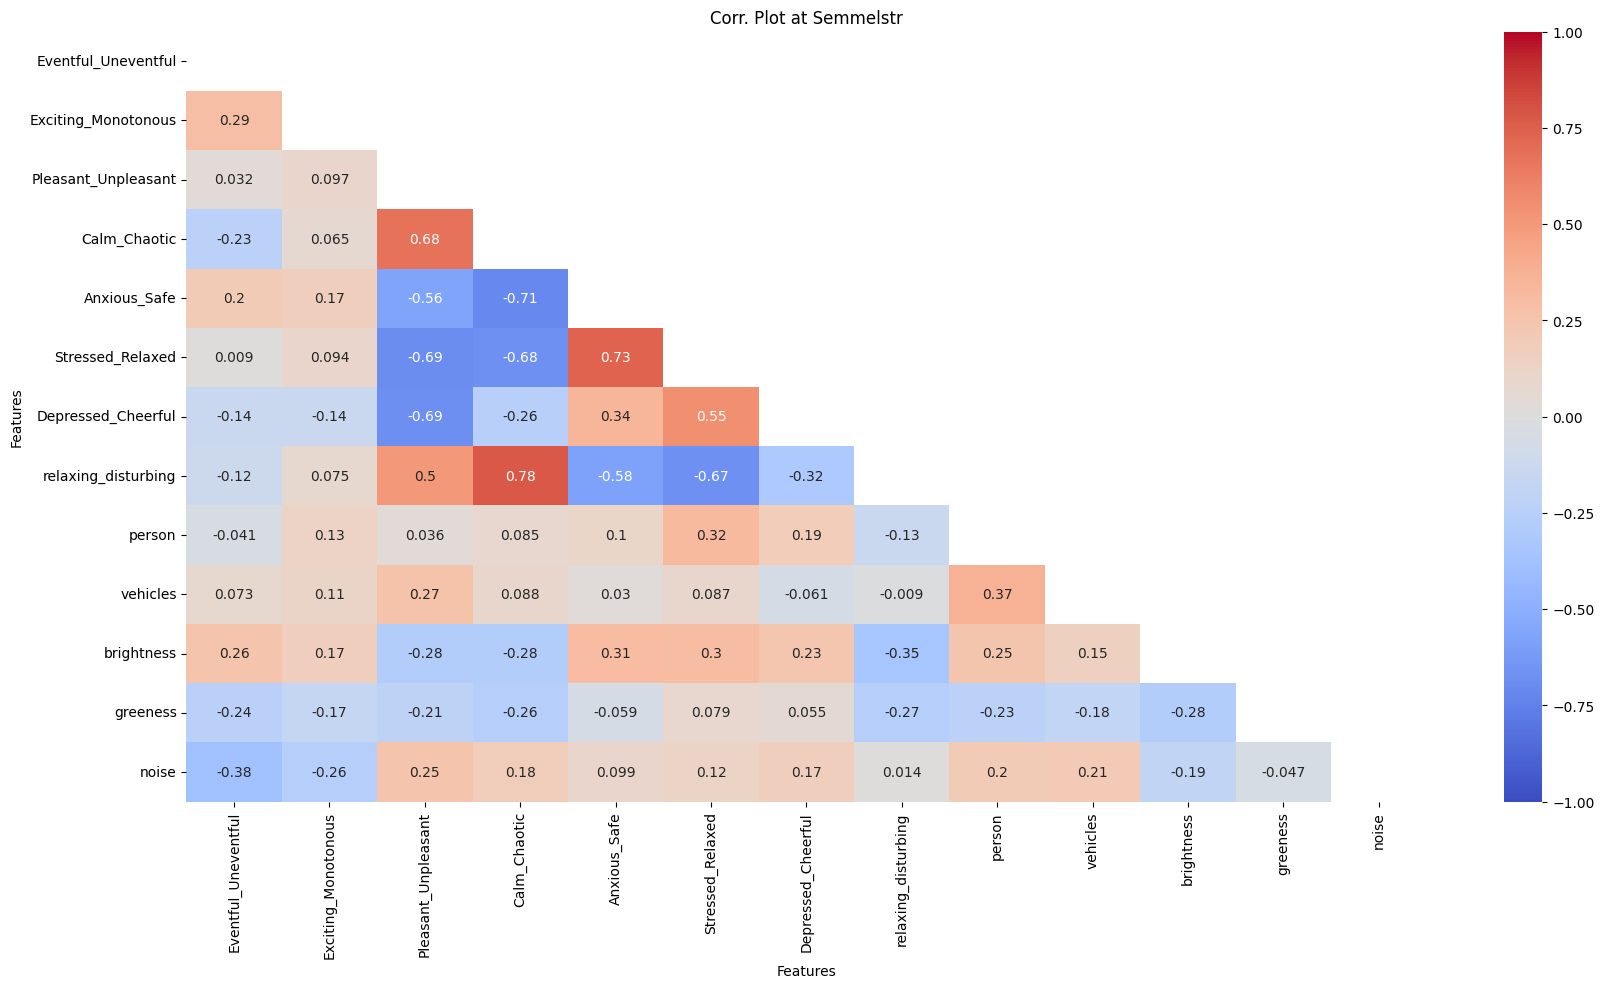

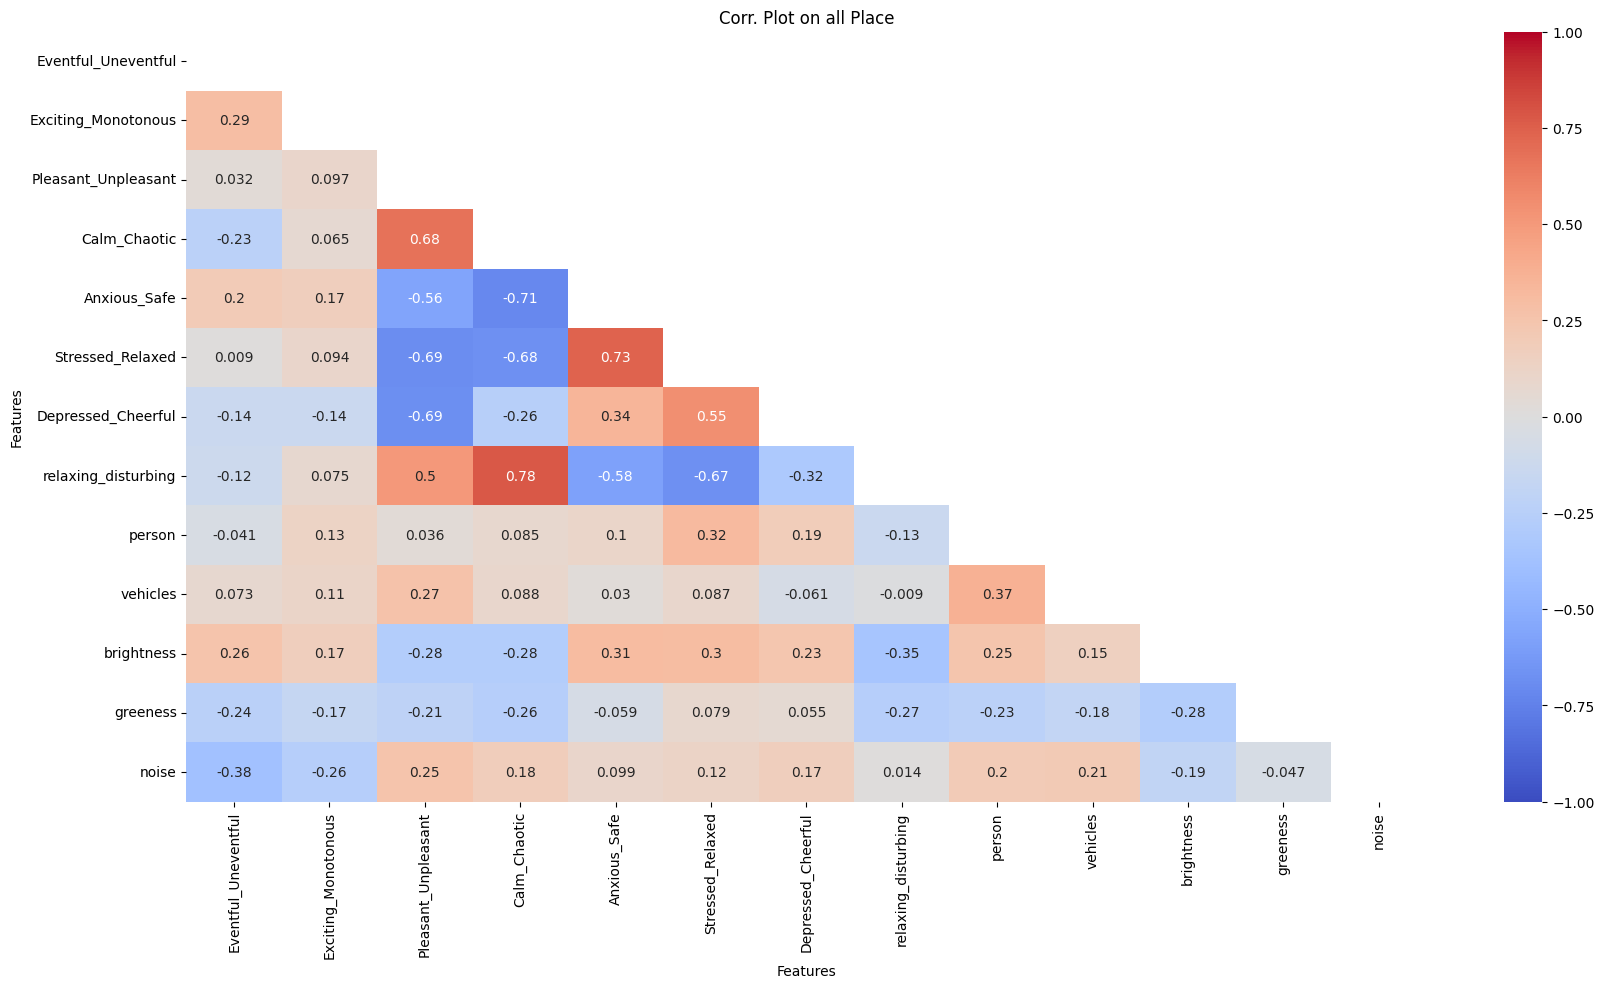

In [49]:
unique_places = mdf.place_name.unique()
for place_name in unique_places:
  fdf = mdf.query('place_name==@place_name')[numerical_cols]
  plot_corr(fdf, f'Corr. Plot at {place_name}', f'corr_{place_name}.png')

fdf = mdf[mdf.place_name==place_name][numerical_cols]
plot_corr(fdf, f'Corr. Plot on all Place', 'corr_all_places.png')



#### Based on the Time of the Day

As we can see from above plots, the correlation varries from person to person and place to place. A best example of such is the correlation between `noise` and `Eventful_Uneventful`. It is negative for some people (e.g. p06) while positive for some persons (e.g. p13). And similarly, it is positive for `Klinikstr` where as negative for `Dommerschulerstr`. Hence one can assume that this discrepancy in correlation might be due to the time of the day. Next, we calculate the hour of the day based on the `observationID` and find correlation for each of it.

<Axes: ylabel='Frequency'>

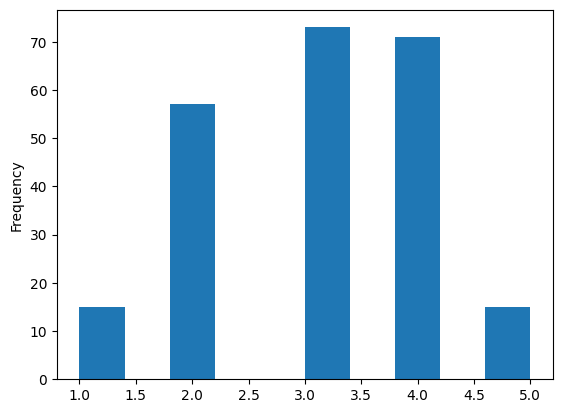

In [50]:
from datetime import datetime
mdf['hour']=mdf['filename'].apply(lambda x: datetime.fromtimestamp(int(x.split('.')[0])/1000)).dt.strftime('%H').astype(int)

mdf.hour.plot(kind='hist')

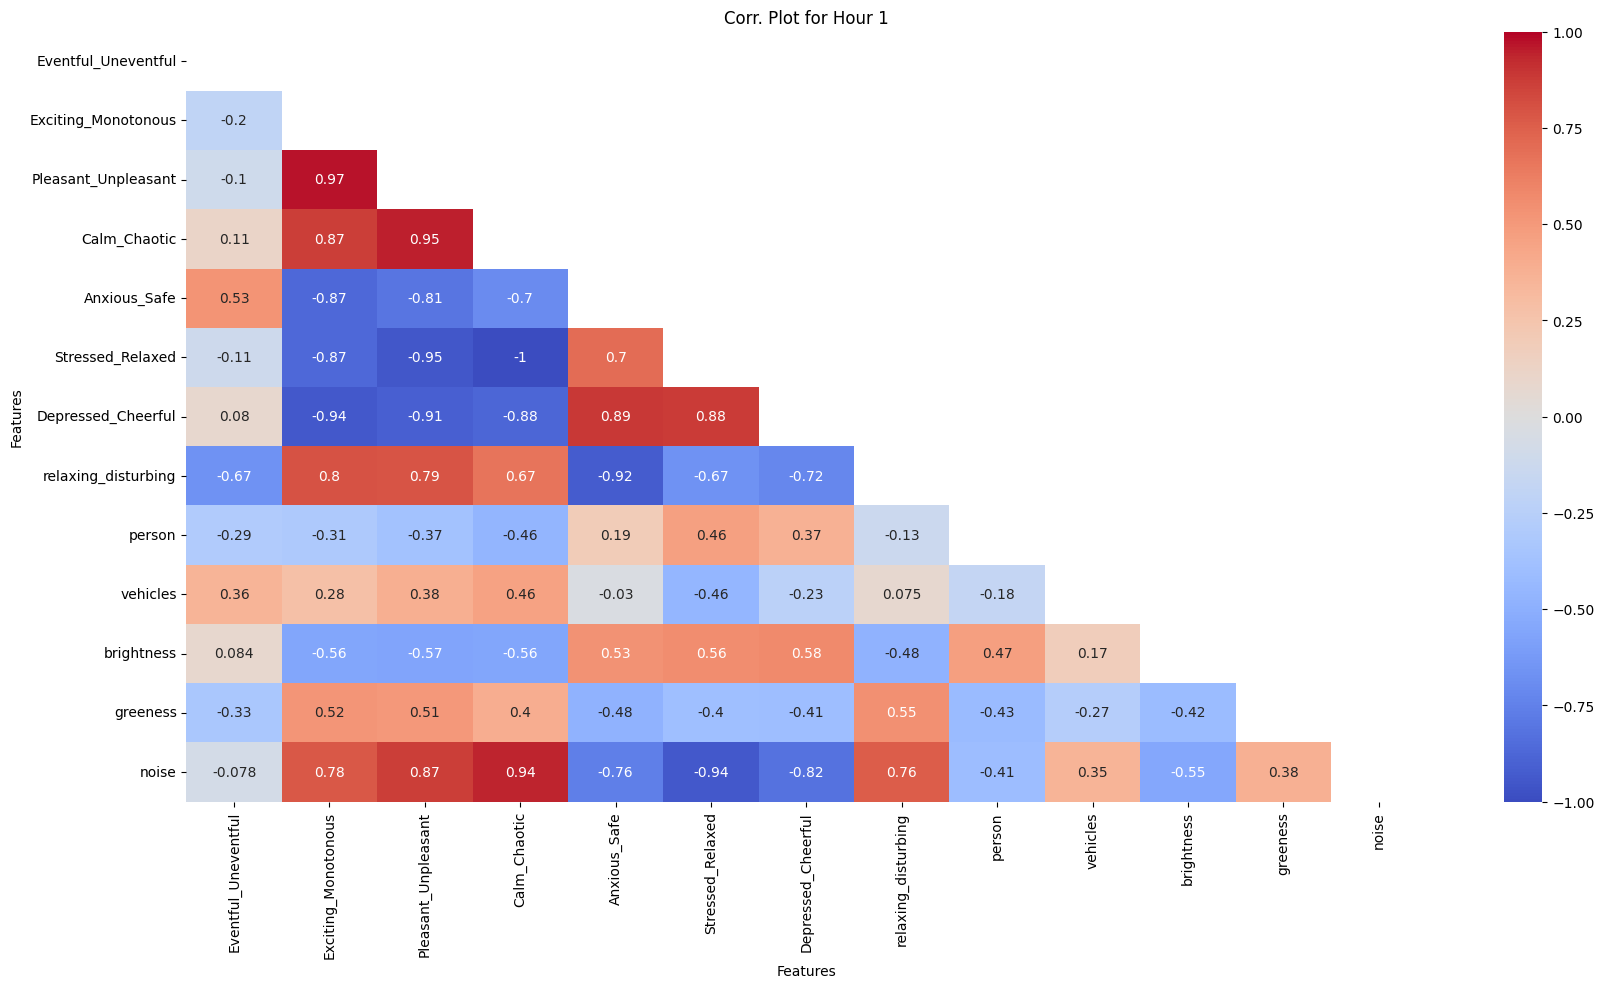

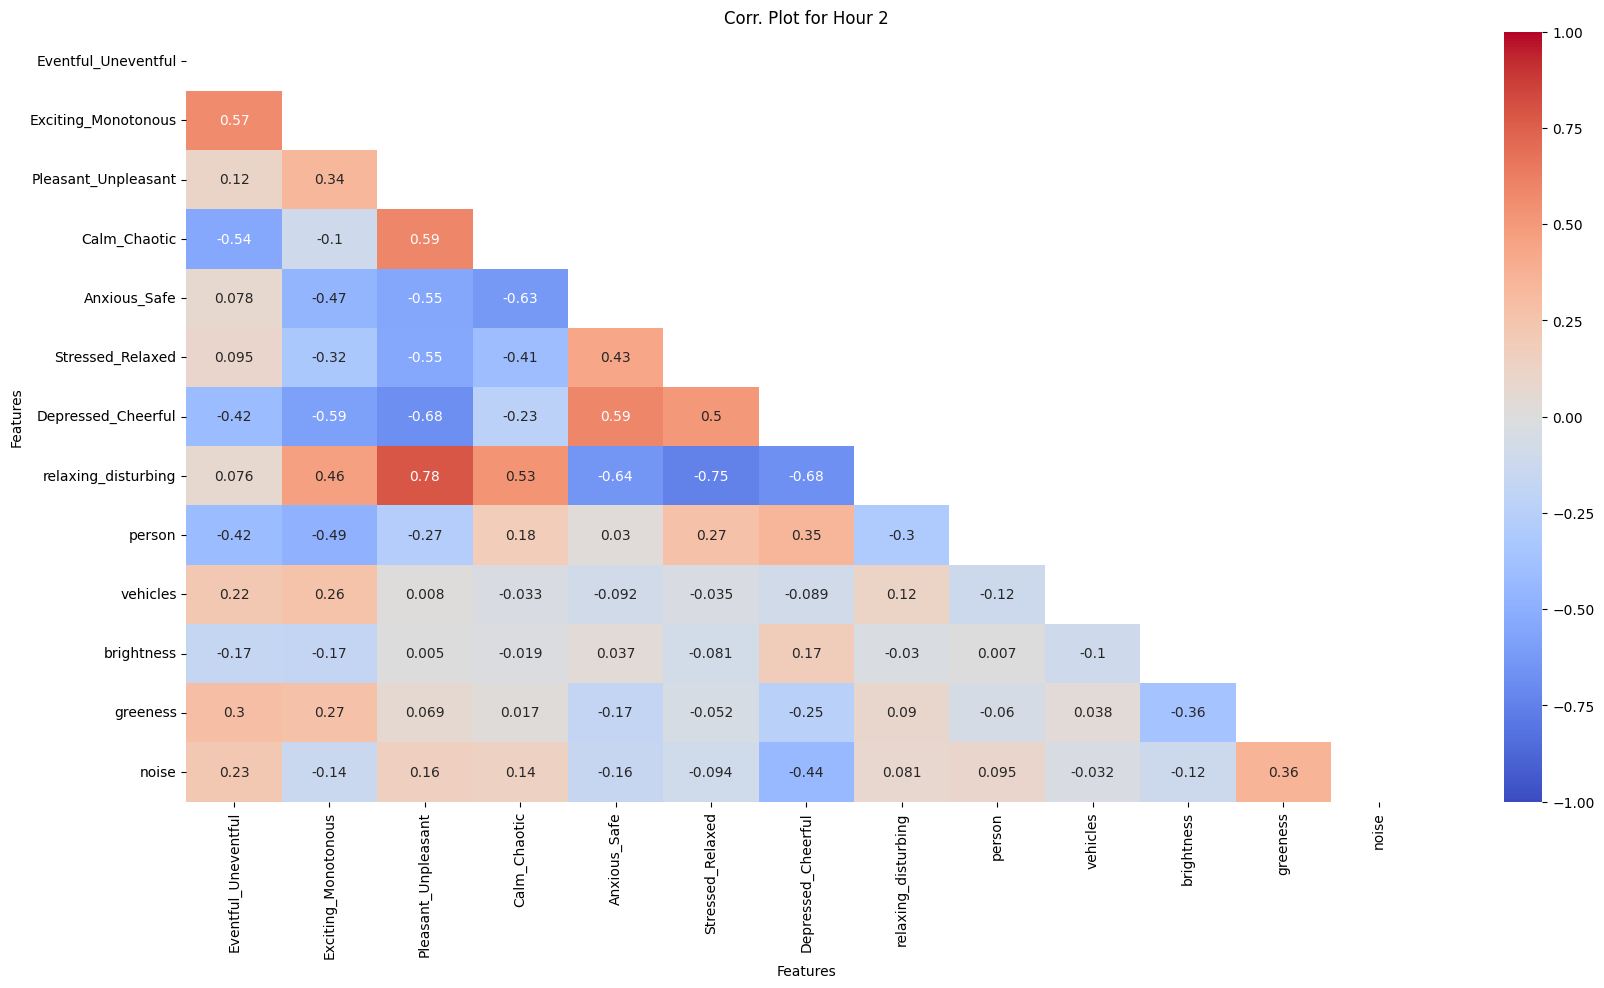

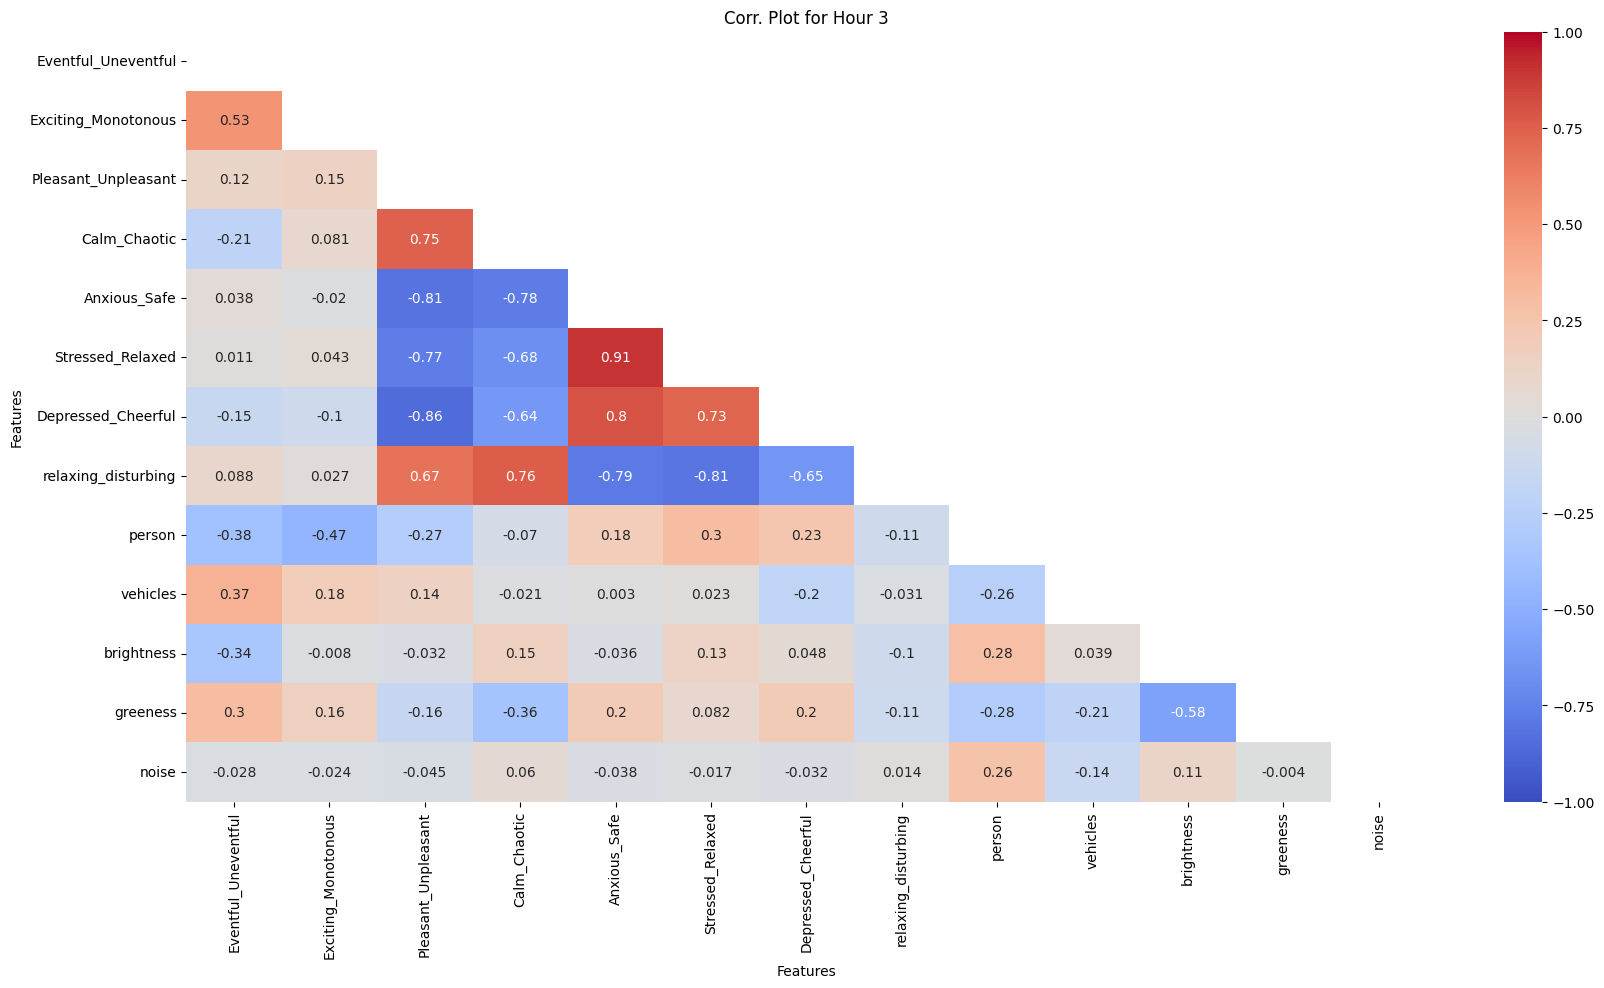

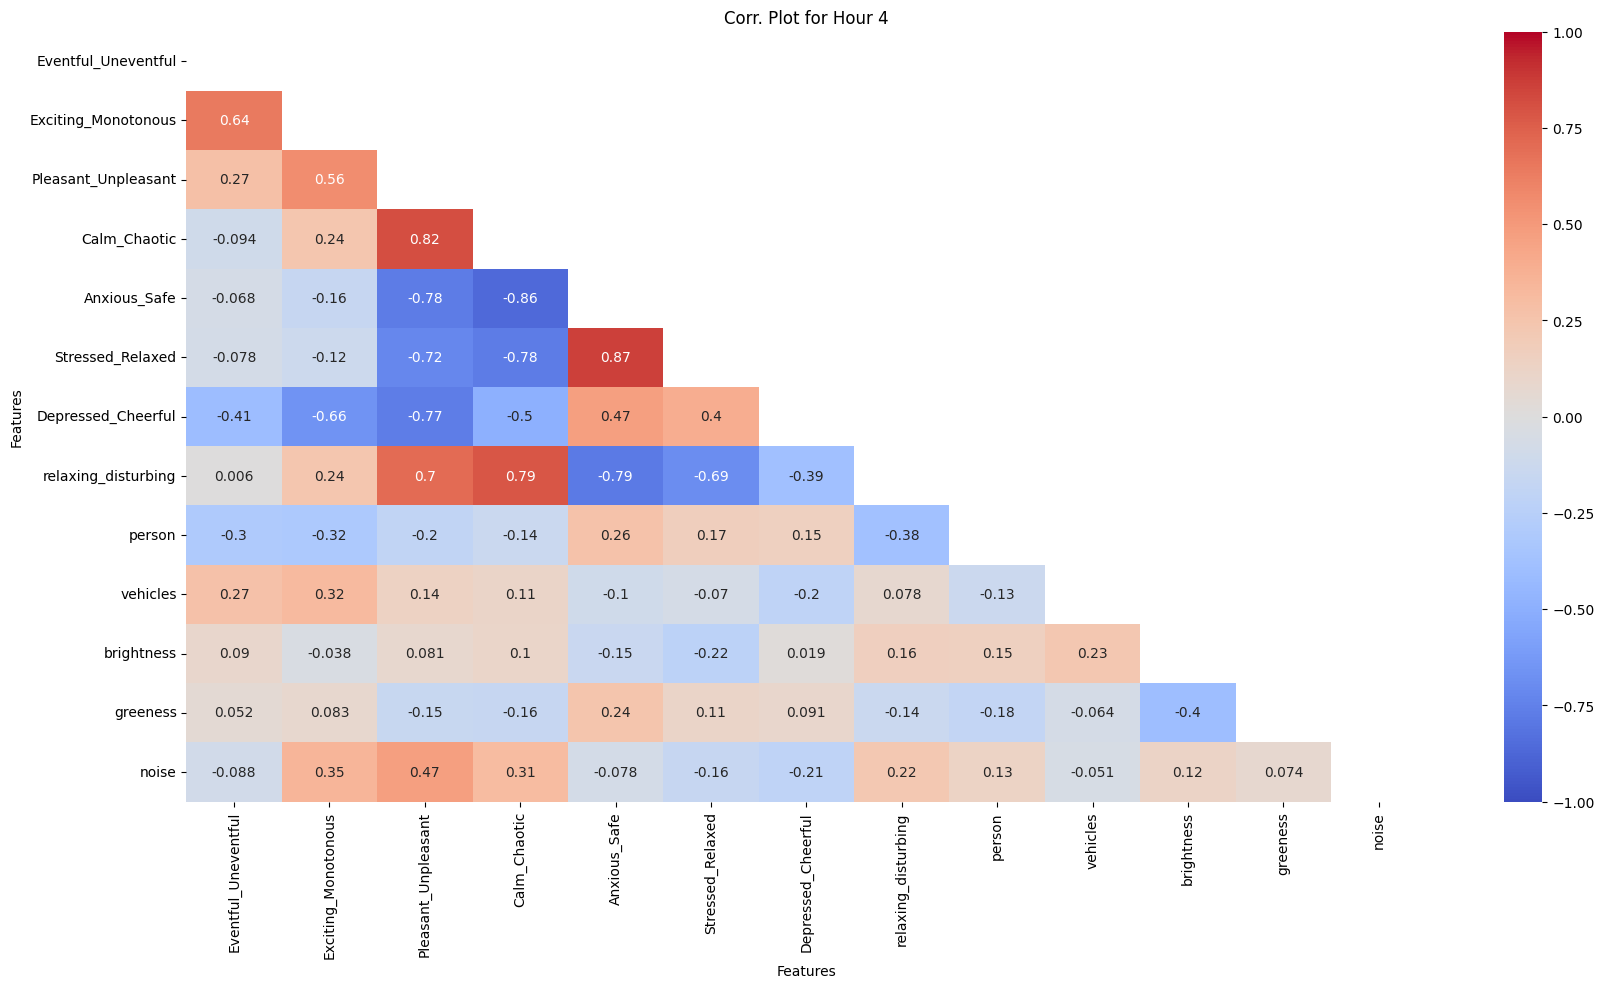

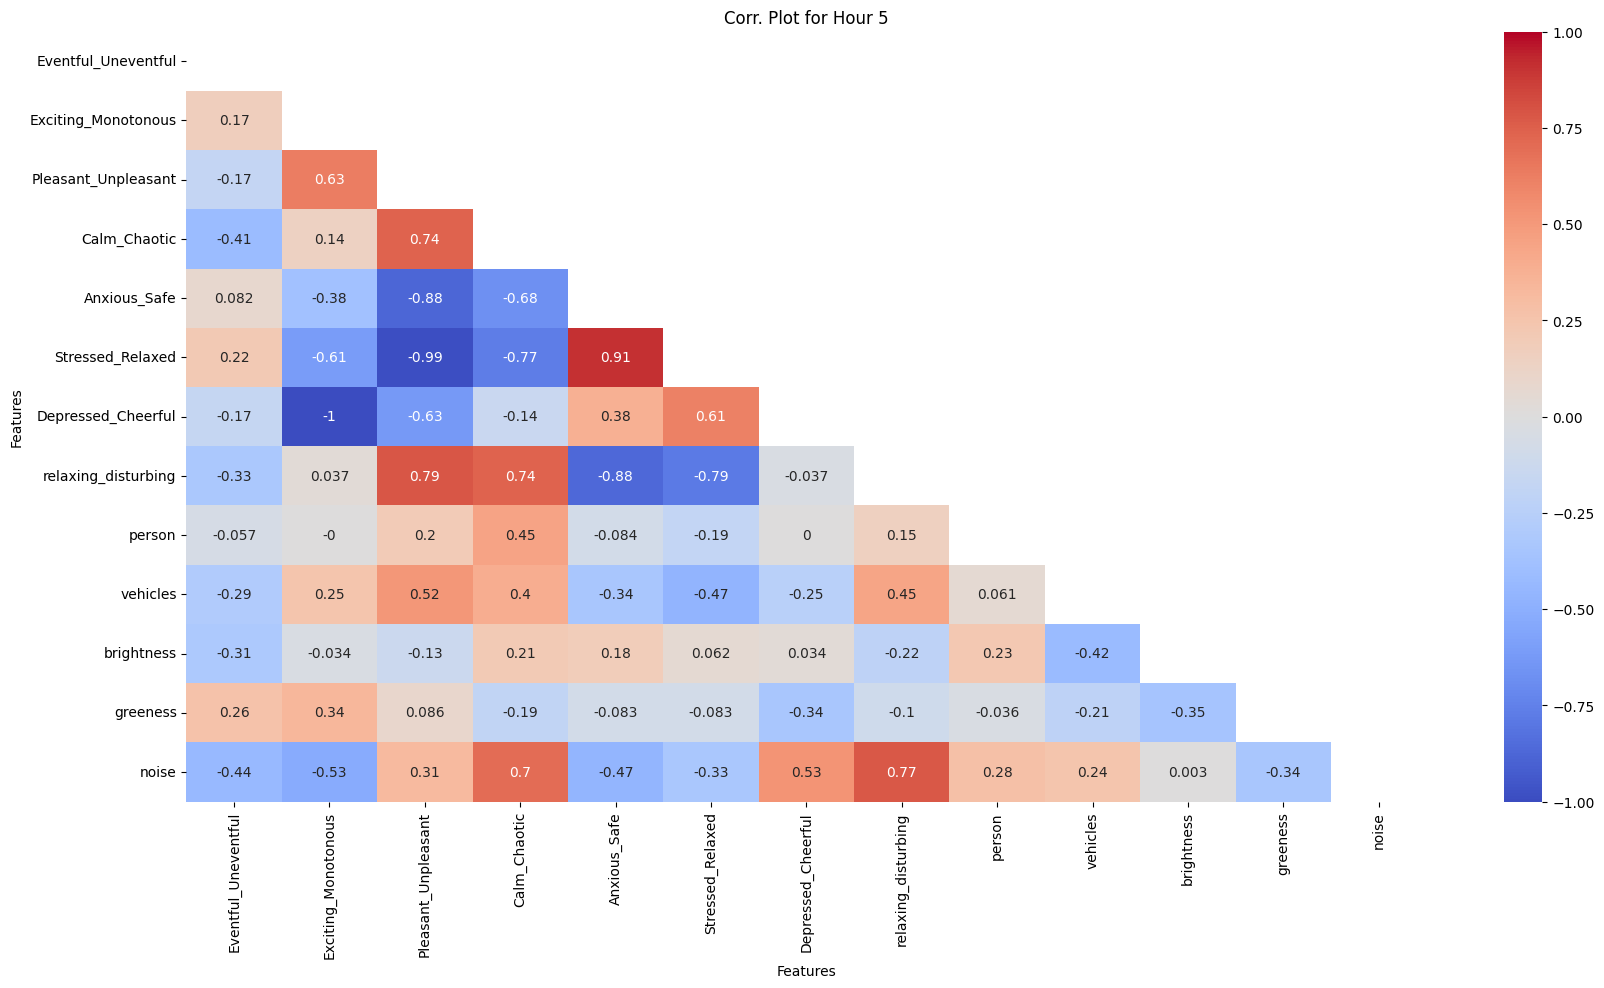

In [51]:
for hour in mdf.hour.unique():
  fdf = mdf[mdf.hour==hour][numerical_cols]
  plot_corr(fdf, f'Corr. Plot for Hour {hour}', f'corr_hour_{hour}.png')

#### Based on Person

## Further Analysis

### Does the correlation varies from person to person?

In [52]:
mdf.to_csv('processed_mdf.csv', index=False)

### What correlation can be seen on other tags?